In [1]:
import ast
import tqdm
import torch
import random
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

## Data preprocessing

In [2]:
books_data = pd.read_csv("books_data.csv")
books_data.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [3]:
books_data = books_data.drop(["image", "previewLink", "infoLink"], axis=1)

In [4]:
books_rating = pd.read_csv("books_rating.csv")
books_rating.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [5]:
books_rating = books_rating.drop(["Id", "Price", "User_id"], axis=1)

In [6]:
reviews = books_rating.merge(books_data, on='Title', how='left')

In [7]:
reviews.isna().sum()

Title                     208
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
description            640225
authors                390634
publisher              782617
publishedDate          354581
categories             551498
ratingsCount          1360694
dtype: int64

In [8]:
reviews = reviews.dropna()

In [9]:
reviews.nunique()

Title                  40434
profileName           463103
review/helpfulness      8494
review/score               5
review/time             5711
review/summary        654152
review/text           835773
description            36507
authors                26673
publisher               4696
publishedDate           6885
categories              1158
ratingsCount             454
dtype: int64

In [10]:
reviews['authors'] = reviews['authors'].apply(lambda x: eval(x))
reviews['categories'] = reviews['categories'].apply(lambda x: eval(x))
reviews['publisher'] = reviews['publisher'].apply(lambda x: [x])

In [11]:
authors_subset_size = 100

unique_authors = set(author for authors in reviews['authors'] for author in authors)
sampled_authors = random.sample(sorted(unique_authors), authors_subset_size)

reviews_mini = reviews[reviews['authors'].apply(lambda authors: any(author in sampled_authors for author in authors))]

In [12]:
reviews_mini.reset_index(drop=True, inplace=True)

In [13]:
len(reviews_mini)

4500

## Graph creation & analysis

In [14]:
G = nx.Graph()

for idx, row in reviews_mini.iterrows():
    G.add_node(idx, rating=row['review/score'])

In [15]:
def add_edges_for_common_attribute(G, reviews, attribute, copy=True):
    if copy:
        G = G.copy()
    attribute_map = defaultdict(list)
    for idx, row in reviews.iterrows():
        for attr in row[attribute]:
            attribute_map[attr].append(idx)
    for nodes in attribute_map.values():
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                G.add_edge(nodes[i], nodes[j], connection=attribute)
    return G

In [16]:
G_authors = add_edges_for_common_attribute(G, reviews_mini, 'authors')
G_categories = add_edges_for_common_attribute(G, reviews_mini, 'categories')
G_publishers = add_edges_for_common_attribute(G, reviews_mini, 'publisher')

In [17]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
embeddings_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embeddings_model = embeddings_model.to(device)

def get_embeddings_batch(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Переносим тензоры на устройство

        with torch.no_grad():
            outputs = embeddings_model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Переносим результат на CPU
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

/home/dmitry_malikov/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
%%time

texts = reviews_mini['review/text'].tolist()
embeddings = get_embeddings_batch(texts, batch_size=64)

reviews_mini['review_embedding'] = list(embeddings)

CPU times: user 14.8 s, sys: 59.2 s, total: 1min 14s
Wall time: 1min 9s


<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
%%time

texts = reviews_mini['description'].tolist()
embeddings = get_embeddings_batch(texts, batch_size=64)

reviews_mini['description_embedding'] = list(embeddings)

CPU times: user 10 s, sys: 24.8 s, total: 34.8 s
Wall time: 30.4 s


<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
def add_edges_with_embeddings(G, reviews, embeddings_col, similarity_threshold=None, neighbors_threshold=None, copy=True):
    if copy:
        G = G.copy()
    embeddings = np.vstack(reviews[embeddings_col].values)
    
    nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(embeddings)
    if similarity_threshold is not None:
        distances, indices = nbrs.radius_neighbors(embeddings, radius=1 - similarity_threshold)
    elif neighbors_threshold is not None:
        distances, indices = nbrs.kneighbors(embeddings, n_neighbors=neighbors_threshold)
    else:
        raise ValueError("One of arguments <similarity_threshold> or <neighbors_threshold> should be provided.")
    
    for i, (neighbor_indices, neighbor_distances) in enumerate(zip(indices, distances)):
        for j, distance in zip(neighbor_indices, neighbor_distances):
            if i != j:
                similarity = 1 - distance
                G.add_edge(i, j, weight=similarity, connection=embeddings_col)

    return G

In [21]:
G_reviews = add_edges_with_embeddings(G, reviews_mini, "review_embedding", similarity_threshold=0.8)

In [22]:
G_descriptions = add_edges_with_embeddings(G, reviews_mini, "description_embedding", similarity_threshold=0.8)

In [23]:
G_all = G.copy()
G_all.add_edges_from(G_authors.edges)
G_all.add_edges_from(G_categories.edges)
G_all.add_edges_from(G_publishers.edges)
G_all.add_edges_from(G_reviews.edges)
G_all.add_edges_from(G_descriptions.edges)

In [24]:
graphs = {
    "All": G_all,
    "Authors": G_authors,
    "Categories": G_categories,
    "Publishers": G_publishers,
    "Reviews": G_reviews,
    "Descriptions": G_descriptions
}

In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def visualize_graph(G, reviews, num_nodes=100, title=None):
    if num_nodes < len(G):
        sampled_nodes = random.sample(sorted(G.nodes()), num_nodes)
        subgraph = G.subgraph(sampled_nodes)
    else:
        subgraph = G

    fig, ax = plt.subplots(figsize=(10, 10))
    pos = nx.spring_layout(subgraph, k=1, iterations=200)

    node_scores = {node: int(reviews.loc[node, 'review/score']) for node in subgraph.nodes}

    cmap = plt.cm.RdYlGn
    norm = plt.Normalize(vmin=1, vmax=5)

    node_colors = [cmap(norm(score)) for score in node_scores.values()]  # Оценки от 1 до 5

    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color=node_colors, edgecolors='black', alpha=0.9, ax=ax)
    nx.draw_networkx_edges(subgraph, pos, width=1, alpha=0.7, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(subgraph, pos, labels={}, font_size=8, font_color="black", ax=ax)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(1)), markersize=10, label='1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(2)), markersize=10, label='2'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(3)), markersize=10, label='3'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(4)), markersize=10, label='4'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(5)), markersize=10, label='5'),
    ]
    ax.legend(handles=legend_elements, title='Review Score', loc='best', frameon=False)

    plt.title(title)
    plt.axis('off')
    plt.show()


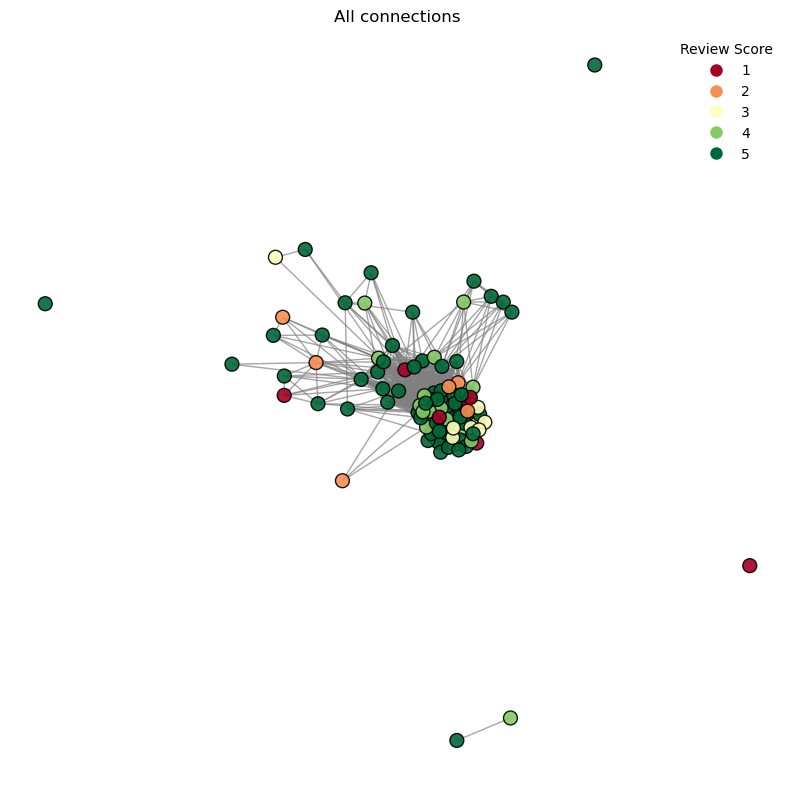

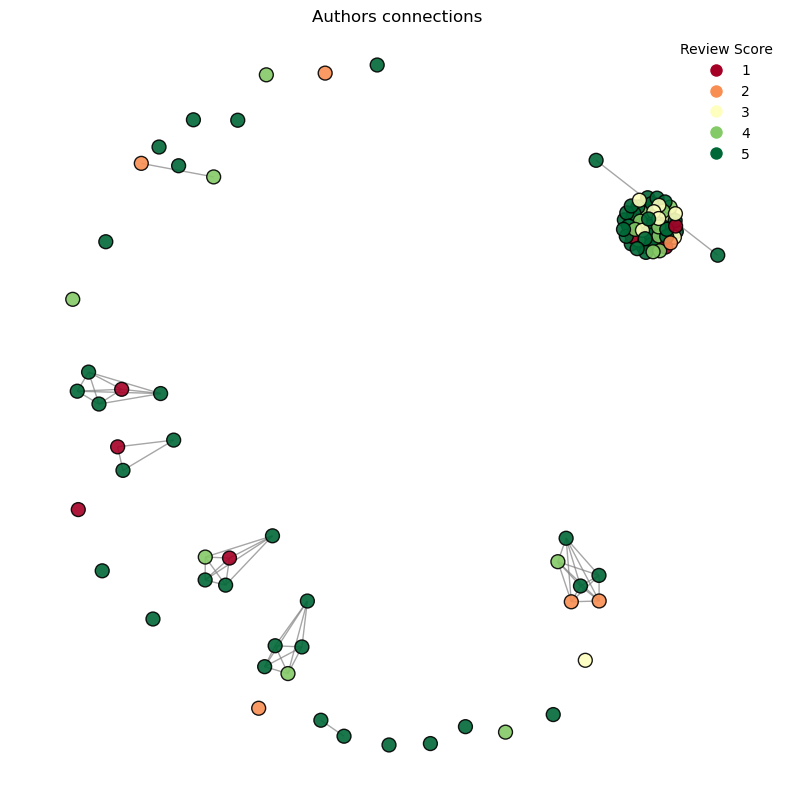

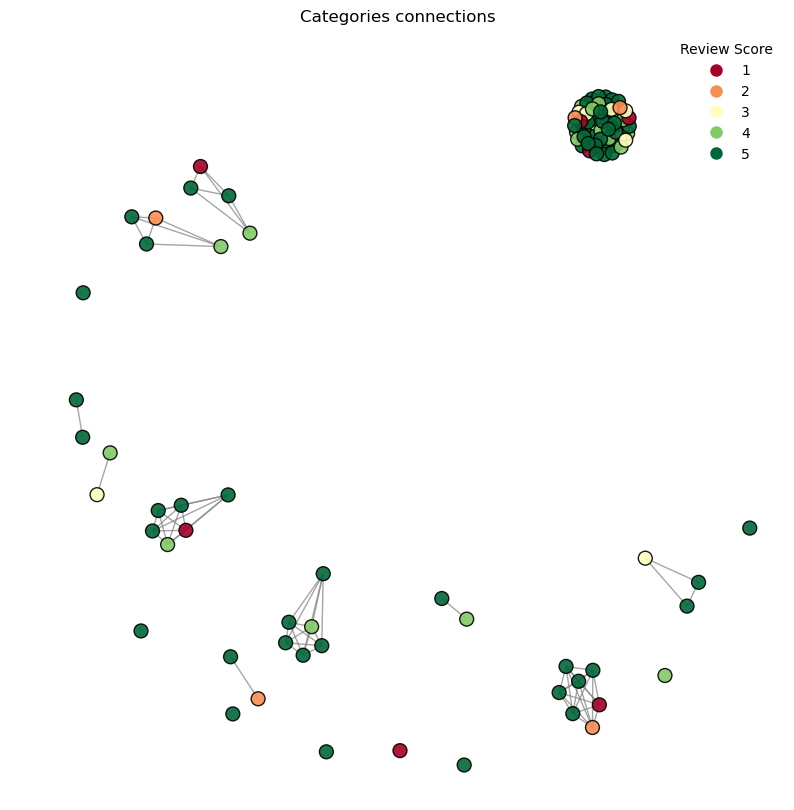

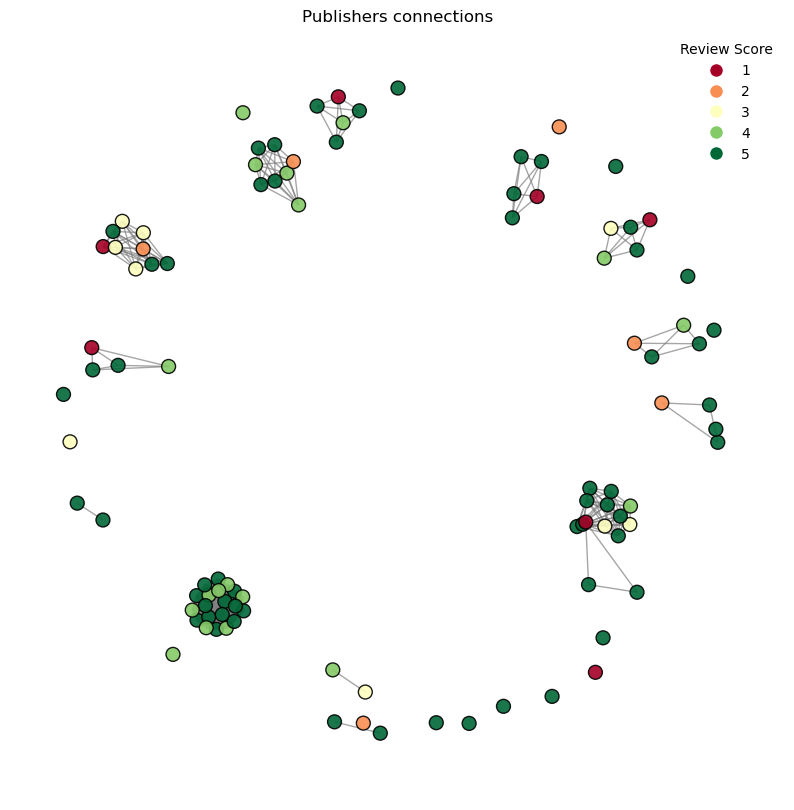

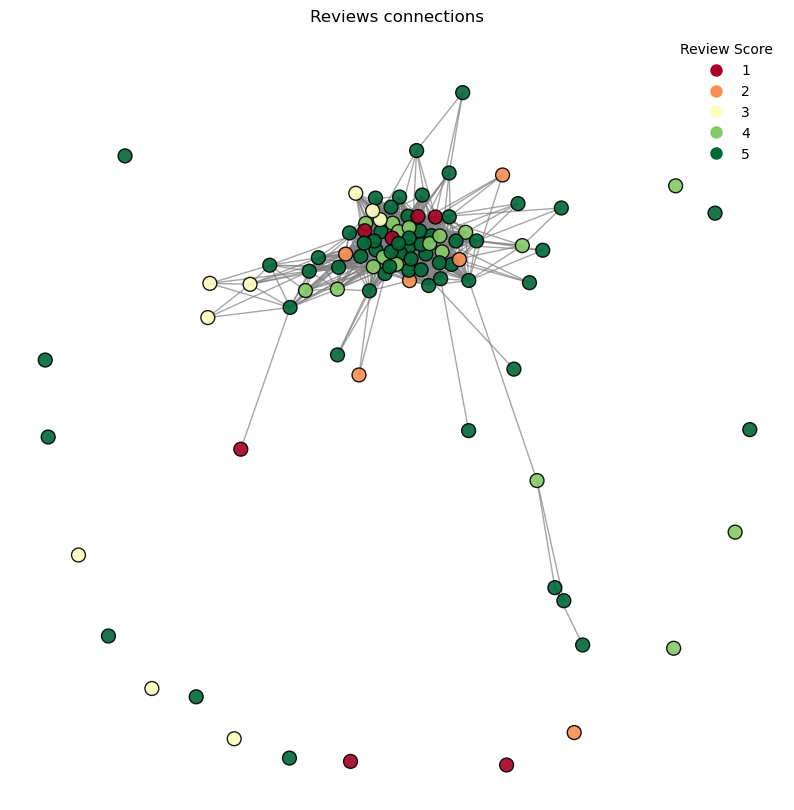

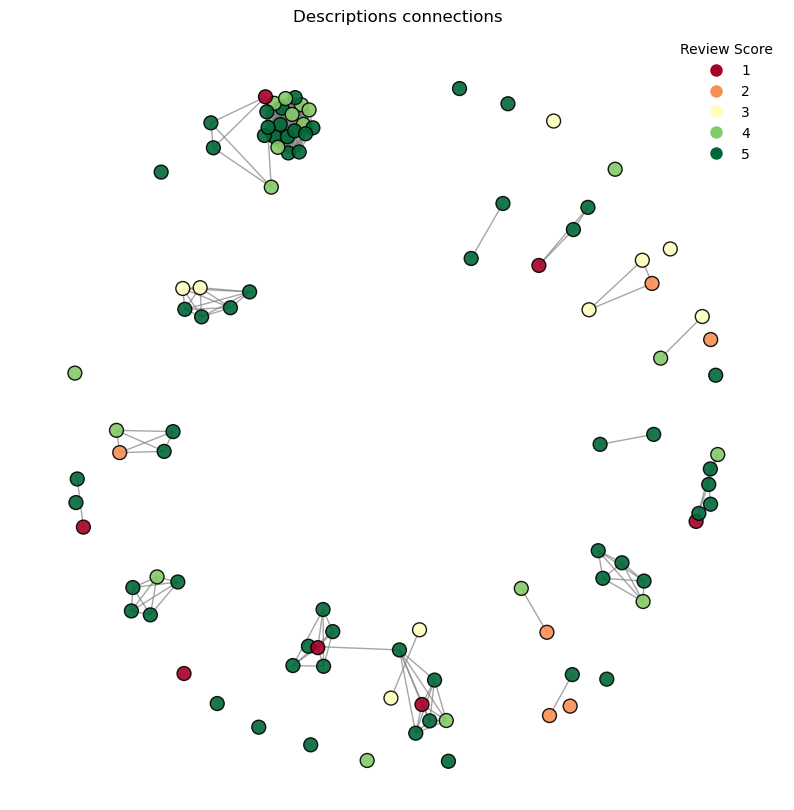

In [26]:
for name, graph in graphs.items():
    random.seed(42) 
    visualize_graph(graph, reviews_mini, num_nodes=100, title=name + " connections")

In [27]:
graph_data = []

for graph_name, graph in graphs.items():
    density = nx.density(graph)
    
    if nx.is_connected(graph):
        diameter = nx.diameter(graph)
    else:
        diameter = None

    graph_data.append({
        "Graph": graph_name,
        "Density": density,
        "Diameter": diameter
    })

df_graph_metrics = pd.DataFrame(graph_data)

print(df_graph_metrics)

          Graph   Density Diameter
0           All  0.478389     None
1       Authors  0.308461     None
2    Categories  0.346992     None
3    Publishers  0.082996     None
4       Reviews  0.241559     None
5  Descriptions  0.060126     None


In [28]:
def get_top_degree_centrality(graph, reviews_df, column,  top_n=3):
    degree_centrality = nx.degree_centrality(graph)
    
    sorted_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

    top_nodes = sorted_nodes[:top_n]
    
    top_texts = []
    for node, _ in top_nodes:
        top_texts.append(reviews_df.loc[node, column])
    
    return top_nodes, top_texts

top_nodes_reviews, top_texts_reviews = get_top_degree_centrality(G_reviews, reviews_mini, "review/text", top_n=3)

print("\nTop 3 nodes for G_reviews (Degree Centrality):")
for i, (node, centrality) in enumerate(top_nodes_reviews):
    print(f"{i+1}. Degree Centrality: {centrality}\nReview Text: {top_texts_reviews[i]}\n")


Top 3 nodes for G_reviews (Degree Centrality):
1. Degree Centrality: 0.6685930206712603
Review Text: I received this book last week and although I haven't read it right through, I have to say it is great fun and has a lot of practical advice for writers. Janet Evanovich believes in the showing not telling mode and it works! I have always been a devoted fan of the mad and engaging character, Stephanie Plum, and now I must congratulate her on having such a clever mum!Diana Hockley

2. Degree Centrality: 0.6652589464325406
Review Text: I received this book last week and although I haven't read it right through, I have to say it is great fun and has a lot of practical advice for writers. Janet Evanovich believes in the showing not telling mode and it works! I have always been a devoted fan of the mad and engaging character, Stephanie Plum, and now I must congratulate her on having such a clever mum!Diana Hockley

3. Degree Centrality: 0.6514781062458324
Review Text: A friend of mine gave 

## Baseline

In [29]:
texts = reviews_mini['review/text'].tolist()
embeddings = get_embeddings_batch(texts, batch_size=64)

X = embeddings
y = reviews_mini['review/score'] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5967


## Base GNN

In [30]:
def create_pyg_graph_with_embeddings(G, reviews_mini, batch_size=64):
    texts = reviews_mini['review/text'].tolist()
    embeddings = get_embeddings_batch(texts, batch_size=batch_size)
    
    node_features = torch.tensor(embeddings, dtype=torch.float)

    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

    labels = torch.tensor([int(reviews_mini.loc[node, 'review/score']) - 1 for node in G.nodes()], dtype=torch.long)

    data = Data(x=node_features, edge_index=edge_index, y=labels)
    return data

data = create_pyg_graph_with_embeddings(G_all, reviews_mini)

In [31]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = torch.dropout(x, self.dropout, train=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = torch.dropout(x, self.dropout, train=self.training)
        
        x = self.conv3(x, edge_index)
        
        return x

input_dim = 384
hidden_dim = 64
output_dim = 5

model = GNNModel(input_dim, hidden_dim, output_dim)

In [32]:
train_mask, test_mask = train_test_split(range(len(data.y)), test_size=0.2, random_state=42)

train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train(model, data, optimizer, criterion, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data, test_mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out[test_mask].max(dim=1)
        correct = (pred == data.y[test_mask]).sum().item()
        accuracy = correct / len(test_mask)
    return accuracy

for epoch in tqdm.trange(10):
    loss = train(model, data, optimizer, criterion, train_mask)

accuracy = test(model, data, test_mask)
print(f'Final accuracy: {accuracy:.4f}')

100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.84s/it]


Final accuracy: 0.5489
